In [37]:
%run -i lmu_laguerre_cell.py

# Importing libraries for LMU
from nengolib.signal import LinearSystem, Identity, cont2discrete
from nengolib.synapses import LegendreDelay

#from lmu_laguerre_cell import LMUCell, LaguerreCell
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.core import Dense
from keras.layers.recurrent import RNN
from keras.models import Sequential, Model
from keras.initializers import Constant
from keras.utils import multi_gpu_model, to_categorical

import matplotlib.pyplot as plt

import os
import sys

In [24]:
# MNIST dataset parameters.
num_features = 784 # data features (img shape: 28*28).

from keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
# Convert to float32.
X_train, X_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
X_train, X_test = x_train.reshape([-1, num_features, 1]), x_test.reshape([-1, num_features, 1])
# Normalize images value from [0, 255] to [0, 1].
X_train, X_test = X_train / 255., X_test / 255.

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (60000, 784, 1)
X_test: (10000, 784, 1)


In [34]:
seed = 42  # to help with reproducibility

from tensorflow import set_random_seed
set_random_seed(seed=seed)
np.random.seed(seed=seed)

n_pixels = 785 - 1
assert n_pixels == 28**2

def laguerre_layer(**kwargs):
    return RNN(LaguerreCell(units = 50,
                        order = 128,
                        a = 0.9,
                        theta=n_pixels,
                        input_encoders_initializer=Constant(1),
                        hidden_encoders_initializer=Constant(0),
                        memory_encoders_initializer=Constant(0),
                        input_kernel_initializer=Constant(0),
                        hidden_kernel_initializer=Constant(0),
                        memory_kernel_initializer='glorot_normal',
                      ),
               return_sequences=False,
               **kwargs)

model = Sequential()
model.add(laguerre_layer(
    input_shape = (None,1)))
model.add(Dense(10, activation='softmax'))

# model = multi_gpu_model(model, gpus=4)

opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_11 (RNN)                 (None, 50)                25641     
_________________________________________________________________
dense_9 (Dense)              (None, 10)                510       
Total params: 26,151
Trainable params: 9,639
Non-trainable params: 16,512
_________________________________________________________________


In [35]:
set_random_seed(seed=seed)
np.random.seed(seed=seed)

import time

batch_size = 100
epochs = 10
fname = os.path.abspath('models/MNIST-laguerre.hdf5')

callbacks = [
    # CSVLogger('log-ctn19-pmnist-dn-090419.csv', append=True, separator=';')
    # EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5),
    ModelCheckpoint(filepath=fname, monitor='val_loss', verbose=1, save_best_only=True),
]

t = time.time()

result = model.fit(
    X_train,
    to_categorical(Y_train),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, to_categorical(Y_test)),
    callbacks=callbacks,
)

print("Took {:.2f} min".format((time.time() - t) / 60))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 300s 5ms/step - loss: 0.5054 - accuracy: 0.8542 - val_loss: 0.2650 - val_accuracy: 0.9237

Epoch 00001: val_loss improved from inf to 0.26505, saving model to /data/home/dorads/Documents/GitHub_Repos/01_Maintained/NeuralODE/test/lmu_test/models/MNIST-laguerre.hdf5
Epoch 2/10
60000/60000 [==============================] - 289s 5ms/step - loss: 0.2213 - accuracy: 0.9349 - val_loss: 0.1873 - val_accuracy: 0.9461

Epoch 00002: val_loss improved from 0.26505 to 0.18729, saving model to /data/home/dorads/Documents/GitHub_Repos/01_Maintained/NeuralODE/test/lmu_test/models/MNIST-laguerre.hdf5
Epoch 3/10
60000/60000 [==============================] - 303s 5ms/step - loss: 0.1780 - accuracy: 0.9467 - val_loss: 0.1653 - val_accuracy: 0.9513

Epoch 00003: val_loss improved from 0.18729 to 0.16533, saving model to /data/home/dorads/Documents/GitHub_Repos/01_Maintained/NeuralODE/test/lmu_test/

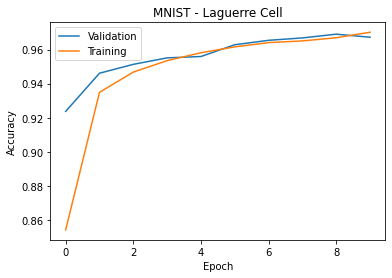

In [39]:
plt.figure()
plt.plot(result.history['val_accuracy'], label="Validation")
plt.plot(result.history['accuracy'], label="Training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MNIST - Laguerre Cell")
plt.show()

In [44]:
seed = 42  # to help with reproducibility

from tensorflow import set_random_seed
set_random_seed(seed=seed)
np.random.seed(seed=seed)

n_pixels = 785 - 1
assert n_pixels == 28**2

def LMU_layer(**kwargs):
    return RNN(LMUCell(units=212,
                       order=256,
                       theta=n_pixels,
                       input_encoders_initializer=Constant(1),
                       hidden_encoders_initializer=Constant(0),
                       memory_encoders_initializer=Constant(0),
                       input_kernel_initializer=Constant(0),
                       hidden_kernel_initializer=Constant(0),
                       memory_kernel_initializer='glorot_normal',
                      ),
               return_sequences=False,
               **kwargs)

model = Sequential()
model.add(LMU_layer(
    input_shape=X_train.shape[1:],  # (nr. of pixels, 1)
))
model.add(Dense(10, activation='softmax'))

# model = multi_gpu_model(model, gpus=4)

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_13 (RNN)                 (None, 212)               165689    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                2130      
Total params: 167,819
Trainable params: 102,027
Non-trainable params: 65,792
_________________________________________________________________


In [45]:
### import time

batch_size = 100
epochs = 10
fname = os.path.abspath('models/MNIST-LMU.hdf5')
print(fname)

callbacks = [
    # CSVLogger('log-ctn19-pmnist-dn-090419.csv', append=True, separator=';')
    # EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5),
    ModelCheckpoint(filepath=fname, monitor='val_loss', verbose=1, save_best_only=True),
]

t = time.time()

result = model.fit(
    X_train,
    to_categorical(Y_train),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, to_categorical(Y_test)),
    callbacks=callbacks,
)

print("Took {:.2f} min".format((time.time() - t) / 60))

/data/home/dorads/Documents/GitHub_Repos/01_Maintained/NeuralODE/test/lmu_test/models/MNIST-LMU.hdf5
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 384s 6ms/step - loss: 0.3213 - accuracy: 0.9037 - val_loss: 0.1731 - val_accuracy: 0.9493

Epoch 00001: val_loss improved from inf to 0.17307, saving model to /data/home/dorads/Documents/GitHub_Repos/01_Maintained/NeuralODE/test/lmu_test/models/MNIST-LMU.hdf5
Epoch 2/10
60000/60000 [==============================] - 379s 6ms/step - loss: nan - accuracy: 0.2628 - val_loss: nan - val_accuracy: 0.0980

Epoch 00002: val_loss did not improve from 0.17307
Epoch 3/10
60000/60000 [==============================] - 379s 6ms/step - loss: nan - accuracy: 0.0987 - val_loss: nan - val_accuracy: 0.0980

Epoch 00003: val_loss did not improve from 0.17307
Epoch 4/10
60000/60000 [==============================] - 374s 6ms/step - loss: nan - accuracy: 0.0987 - val_loss: nan - val_accuracy: 0.0980

